In [1]:
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.stats import ttest_ind
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
from shapely.geometry import Point
from shapely.geometry import shape
from shapely.geometry import box
import os
from glob import glob
import itertools
import cmaps
from scipy.stats.stats import pearsonr
import rasterio
import rioxarray
import seaborn as sns

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

os.chdir('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data')

# calculate the risk ratio of SWEI due to anthropogenic activities and ENSO envents

In [2]:
# Figrue3a to plot the distribution of SWEI under historical and NAT senarios
hist_source = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CNRM-CM6-1', 'CanESM5', 'CanESM5-1', 'E3SM-1-0', 'E3SM-2-0',
'EC-Earth3','EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','GISS-E2-1-H','GISS-E2-2-G','HadGEM3-GC31-LL','IPSL-CM5A2-INCA',
'IPSL-CM6A-LR','KIOST-ESM','MIROC6','MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-LM','NorESM2-MM','TaiESM1']
NAT_source = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'E3SM-2-0',
'GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL', 'IPSL-CM6A-LR','MIROC6', 'MRI-ESM2-0','NorESM2-LM']

# read in the data
obs_SWEI_yearly = pd.read_csv('SWEI_year_ts.csv', index_col = 0)
obs_SWEI_yearly.index = pd.to_datetime(obs_SWEI_yearly.index)

CMIP6_hist_SWEI_yearly = pd.read_csv('CMIP6_hist/SWEI_year_ts_all_hist.csv', index_col = 0)
CMIP6_hist_SWEI_yearly.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year

CMIP6_NAT_SWEI_yearly = pd.read_csv('CMIP6_NAT/SWEI_year_ts_all_NAT.csv', index_col = 0)
CMIP6_NAT_SWEI_yearly.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS')

hist_nino3 = pd.read_csv('CMIP6_hist/tos_Nino3_index_1950-2025.csv', index_col = 0)
hist_nino3.index = pd.to_datetime(hist_nino3.index)
NAT_nino3 = pd.read_csv('CMIP6_NAT/tos_Nino3_index_1950-2020.csv', index_col = 0)
NAT_nino3.index = pd.to_datetime(NAT_nino3.index)


In [3]:
# select SWEI of EL Nino and La Nina years for each climate model under historical and NAT scenarios

CMIP6_hist_SWEI_yearly_nino = pd.DataFrame()
CMIP6_hist_SWEI_yearly_nino.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_SWEI_yearly_nina = pd.DataFrame()
CMIP6_hist_SWEI_yearly_nina.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_SWEI_yearly_normal = pd.DataFrame()
CMIP6_hist_SWEI_yearly_normal.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SWEI_yearly_nino = pd.DataFrame()
CMIP6_NAT_SWEI_yearly_nino.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SWEI_yearly_nina = pd.DataFrame()
CMIP6_NAT_SWEI_yearly_nina.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SWEI_yearly_normal = pd.DataFrame()
CMIP6_NAT_SWEI_yearly_normal.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year

for sn in hist_source:
    NINO3 = hist_nino3[sn]
    NINO3 = NINO3['1979':'2022']
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    NINO3_QS_DJF.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year

    SWEI = CMIP6_hist_SWEI_yearly[sn]
    SWEI = SWEI['1979':'2022']
    SWEI_nino = SWEI.loc[NINO3_QS_DJF[NINO3_QS_DJF > 0.5].index,]
    CMIP6_hist_SWEI_yearly_nino[sn] = SWEI_nino
    SWEI_nina = SWEI.loc[NINO3_QS_DJF[NINO3_QS_DJF < -0.5].index,]
    CMIP6_hist_SWEI_yearly_nina[sn] = SWEI_nina
    SWEI_normal = SWEI.loc[NINO3_QS_DJF[(NINO3_QS_DJF < 0.5) & (NINO3_QS_DJF > -0.5)].index,]
    CMIP6_hist_SWEI_yearly_normal[sn] = SWEI_normal

for sn in NAT_source:
    NINO3 = NAT_nino3[sn]
    NINO3 = NINO3['1970':'2019']
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    NINO3_QS_DJF.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year

    SWEI = CMIP6_NAT_SWEI_yearly[sn]
    SWEI = SWEI['1970':'2019']
    SWEI_nino = SWEI.loc[NINO3_QS_DJF[NINO3_QS_DJF > 0.5].index,]
    CMIP6_NAT_SWEI_yearly_nino[sn] = SWEI_nino
    SWEI_nina = SWEI.loc[NINO3_QS_DJF[NINO3_QS_DJF < -0.5].index,]
    CMIP6_NAT_SWEI_yearly_nina[sn] = SWEI_nina
    SWEI_normal = SWEI.loc[NINO3_QS_DJF[(NINO3_QS_DJF < 0.5) & (NINO3_QS_DJF > -0.5)].index,]
    CMIP6_NAT_SWEI_yearly_normal[sn] = SWEI_normal

<Axes: >

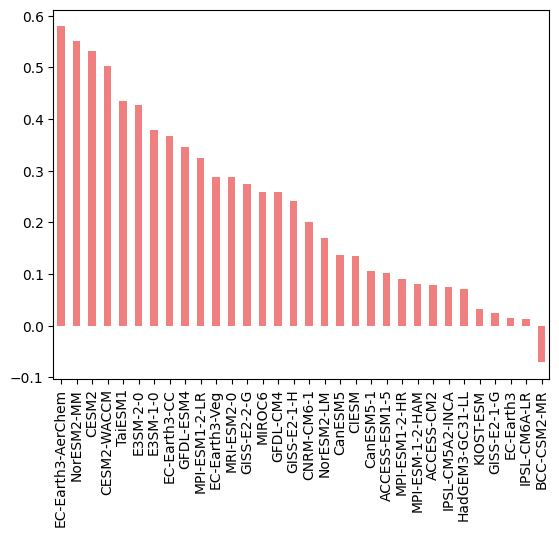

In [4]:
CMIP6_hist_SWEI_yearly_nino.mean(axis=0,skipna=True).sort_values(ascending = False).plot(kind = 'bar', color = 'lightcoral')

<Axes: >

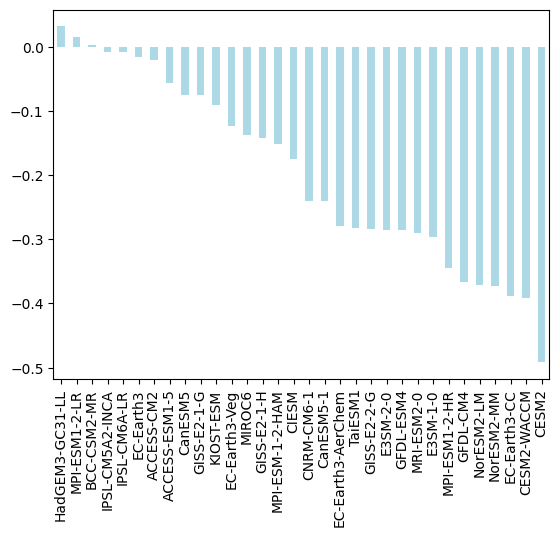

In [5]:
CMIP6_hist_SWEI_yearly_nina.mean(axis=0,skipna=True).sort_values(ascending = False).plot(kind = 'bar', color = 'lightblue')

<Axes: >

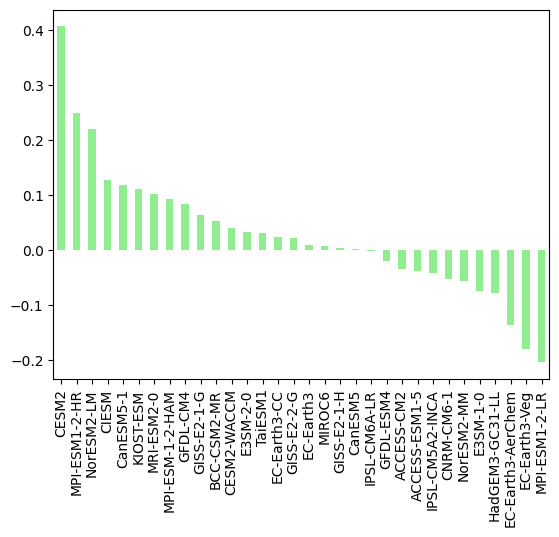

In [6]:
CMIP6_hist_SWEI_yearly_normal.mean(axis=0,skipna=True).sort_values(ascending = False).plot(kind = 'bar', color = 'lightgreen')

In [7]:
obs_SWEI_2020_2022 = obs_SWEI_yearly['2020':'2022'].mean(axis=0,skipna=True)

CMIP6_hist_SWEI_yearly_stack = CMIP6_hist_SWEI_yearly.stack().reset_index()
CMIP6_hist_SWEI_yearly_nino_stack = CMIP6_hist_SWEI_yearly_nino.stack().reset_index()
CMIP6_hist_SWEI_yearly_nina_stack = CMIP6_hist_SWEI_yearly_nina.stack().reset_index()
CMIP6_hist_SWEI_yearly_normal_stack = CMIP6_hist_SWEI_yearly_normal.stack().reset_index()

CMIP6_NAT_SWEI_yearly_nino_stack = CMIP6_NAT_SWEI_yearly_nino.stack().reset_index()
CMIP6_NAT_SWEI_yearly_nina_stack = CMIP6_NAT_SWEI_yearly_nina.stack().reset_index()
CMIP6_NAT_SWEI_yearly_normal_stack = CMIP6_NAT_SWEI_yearly_normal.stack().reset_index()
CMIP6_NAT_SWEI_yearly_stack = CMIP6_NAT_SWEI_yearly.stack().reset_index()

<Axes: xlabel='0', ylabel='Density'>

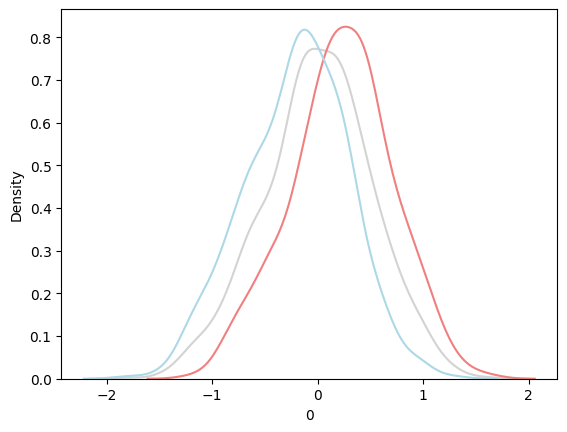

In [8]:
# plot the probability density function
import seaborn as sns
sns.kdeplot(CMIP6_hist_SWEI_yearly_stack[0], color = 'lightgrey')
sns.kdeplot(CMIP6_hist_SWEI_yearly_nino_stack[0], color = 'lightcoral')
sns.kdeplot(CMIP6_hist_SWEI_yearly_nina_stack[0], color = 'lightblue')
# sns.kdeplot(CMIP6_hist_SWEI_yearly_normal_stack[0], color = 'lightgreen')

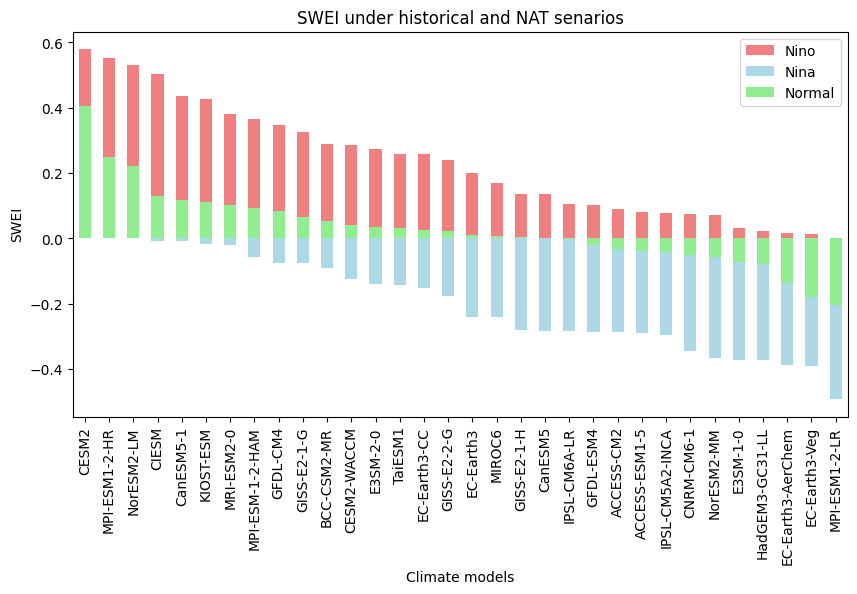

In [9]:
# plot the distribution of SWEI under historical and NAT senarios
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
CMIP6_hist_SWEI_yearly_nino.mean(axis=0,skipna=True).sort_values(ascending = False).plot(kind = 'bar', color = 'lightcoral', ax = ax)
CMIP6_hist_SWEI_yearly_nina.mean(axis=0,skipna=True).sort_values(ascending = False).plot(kind = 'bar', color = 'lightblue', ax = ax)
CMIP6_hist_SWEI_yearly_normal.mean(axis=0,skipna=True).sort_values(ascending = False).plot(kind = 'bar', color = 'lightgreen', ax = ax)
ax.set_ylabel('SWEI')
ax.set_xlabel('Climate models')
ax.set_title('SWEI under historical and NAT senarios')
ax.legend(['Nino', 'Nina', 'Normal'])
plt.show()

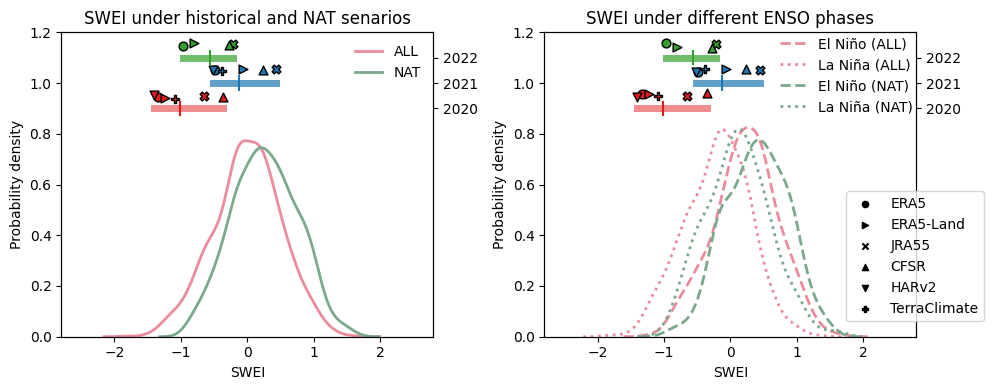

In [10]:
# plot the probability density function of SWEI under historical and NAT senarios
# in a 1 * 1 figure, different colors represent different scenarios, different line types represent different ENSO phases
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.kdeplot(CMIP6_hist_SWEI_yearly_stack[0], color = '#eb8c9d', ax = ax[0], linestyle = '-',linewidth = 2)
sns.kdeplot(CMIP6_NAT_SWEI_yearly_stack[0], color = '#7aa98b', ax = ax[0], linestyle = '-',linewidth = 2)
sns.kdeplot(CMIP6_hist_SWEI_yearly_nino_stack[0], color = '#eb8c9d', ax = ax[1], linestyle = '--', linewidth = 2)
sns.kdeplot(CMIP6_hist_SWEI_yearly_nina_stack[0], color = '#eb8c9d', ax = ax[1], linestyle = ':' , linewidth = 2)
sns.kdeplot(CMIP6_NAT_SWEI_yearly_nino_stack[0], color = '#7aa98b', ax = ax[1], linestyle = '--', linewidth = 2)
sns.kdeplot(CMIP6_NAT_SWEI_yearly_nina_stack[0], color = '#7aa98b', ax = ax[1], linestyle = ':', linewidth = 2)
ax[0].set_ylabel('Probability density')
ax[0].set_xlabel('SWEI')
ax[0].set_xlim(-2.8, 2.8)
ax[0].set_ylim(0, 1.2)
ax[0].set_title('SWEI under historical and NAT senarios')
ax[0].legend(['ALL', 'NAT'], fontsize = 10, fancybox = False, frameon = False)
# add vertical lines to indicate the value of obs_SWEI_2020_2022
obs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']


ax[1].set_ylabel('Probability density')
ax[1].set_xlabel('SWEI')
ax[1].set_xlim(-2.8, 2.8)
ax[1].set_ylim(0, 1.2)
ax[1].set_title('SWEI under different ENSO phases')
ax[1].legend(['El Niño (ALL)', 'La Niña (ALL)', 'El Niño (NAT)', 'La Niña (NAT)'], loc = 'upper right', bbox_to_anchor=(1.025,1.025), fontsize = 10, fancybox = False, frameon = False)


# create twin axis to plot the boxplot
ax2 = ax[0].twinx()
mean_2020 = obs_SWEI_yearly['2020':'2020'].mean(axis=1)
mean_2021 = obs_SWEI_yearly['2021':'2021'].mean(axis=1)
mean_2022 = obs_SWEI_yearly['2022':'2022'].mean(axis=1)
ax2.plot([obs_SWEI_yearly['2020':'2020'].stack().min(), obs_SWEI_yearly['2020':'2020'].stack().max()], [0.9, 0.9], color = obs_colors[5], linestyle = '-', linewidth = 5, alpha = 0.5)
ax2.plot([obs_SWEI_yearly['2021':'2021'].stack().min(), obs_SWEI_yearly['2021':'2021'].stack().max()], [1.0, 1.0], color = obs_colors[1], linestyle = '-', linewidth = 5, alpha = 0.7)
ax2.plot([obs_SWEI_yearly['2022':'2022'].stack().min(), obs_SWEI_yearly['2022':'2022'].stack().max()], [1.1, 1.1], color = obs_colors[3], linestyle = '-', linewidth = 5, alpha = 0.7)
ax2.set_ylim(0, 1.2)
ax2.vlines(mean_2020.values, ymax=0.9+0.03, ymin=0.9-0.03, color = obs_colors[5], linestyle = '-')
ax2.vlines(mean_2021.values, ymax=1.0+0.03, ymin=1.0-0.03, color = obs_colors[1], linestyle = '-')
ax2.vlines(mean_2022.values, ymax=1.1+0.03, ymin=1.1-0.03, color = obs_colors[3], linestyle = '-')

ax2.set_yticks([ 0.9,1.0, 1.1])
ax2.set_yticklabels([2020, 2021, 2022])

def rand_jitter(num):
    return num + np.random.randn() * 0.005

for i,rn in enumerate(['ERA5', 'ERA5-Land', 'JRA55', 'CFSR', 'HARv2', 'TerraClimate']):# with different markers, add random value to avoid overlap
    ax2.scatter(obs_SWEI_yearly.T['2020-01-01'][rn], rand_jitter(0.95), color = obs_colors[5], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax2.scatter(obs_SWEI_yearly.T['2021-01-01'][rn], rand_jitter(1.05), color = obs_colors[1], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax2.scatter(obs_SWEI_yearly.T['2022-01-01'][rn], rand_jitter(1.15), color = obs_colors[3], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')

ax3 = ax[1].twinx()
ax3.plot([obs_SWEI_yearly['2020':'2020'].stack().min(), obs_SWEI_yearly['2020':'2020'].stack().max()], [0.9, 0.9], color = obs_colors[5], linestyle = '-', linewidth = 5, alpha = 0.5)
ax3.plot([obs_SWEI_yearly['2021':'2021'].stack().min(), obs_SWEI_yearly['2021':'2021'].stack().max()], [1.0, 1.0], color = obs_colors[1], linestyle = '-', linewidth = 5, alpha = 0.7)
ax3.plot([obs_SWEI_yearly['2022':'2022'].stack().min(), obs_SWEI_yearly['2022':'2022'].stack().max()], [1.1, 1.1], color = obs_colors[3], linestyle = '-', linewidth = 5, alpha = 0.7)
ax3.set_ylim(0, 1.2)
ax3.vlines(mean_2020.values, ymax=0.9+0.03, ymin=0.9-0.03, color = obs_colors[5], linestyle = '-')
ax3.vlines(mean_2021.values, ymax=1.0+0.03, ymin=1.0-0.03, color = obs_colors[1], linestyle = '-')
ax3.vlines(mean_2022.values, ymax=1.1+0.03, ymin=1.1-0.03, color = obs_colors[3], linestyle = '-')
ax3.set_yticks([ 0.9, 1.0, 1.1])
ax3.set_yticklabels([2020, 2021, 2022])

# add legend for scatter plot
ax3.scatter([],[], color = 'black', s = 20, marker = 'o', label = 'ERA5')
ax3.scatter([],[], color = 'black', s = 20, marker = '>', label = 'ERA5-Land')
ax3.scatter([],[], color = 'black', s = 20, marker = 'x', label = 'JRA55')
ax3.scatter([],[], color = 'black', s = 20, marker = '^', label = 'CFSR')
ax3.scatter([],[], color = 'black', s = 20, marker = 'v', label = 'HARv2')
ax3.scatter([],[], color = 'black', s = 20, marker = 'P', label = 'TerraClimate')
ax3.legend(loc = 'upper right', bbox_to_anchor=(1.2, 0.5), fontsize = 10)

for i,rn in enumerate(['ERA5', 'ERA5-Land', 'JRA55', 'CFSR', 'HARv2', 'TerraClimate']):# with different markers, add random value to avoid overlap
    ax3.scatter(obs_SWEI_yearly.T['2020-01-01'][rn], rand_jitter(0.95), color = obs_colors[5], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax3.scatter(obs_SWEI_yearly.T['2021-01-01'][rn], rand_jitter(1.05), color = obs_colors[1], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax3.scatter(obs_SWEI_yearly.T['2022-01-01'][rn], rand_jitter(1.15), color = obs_colors[3], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')

ax[0].grid(False)
ax[1].grid(False)
ax2.grid(False)
ax3.grid(False)

plt.tight_layout()

In [11]:
# calculate risk ratio of observed SWEI, the risk ratio is defined as the ratio of the probability of SWEI being lower than the 2020-2022 average under historical senario to the probability of SWEI being lower than the 2020-2022 average under NAT senario
# the risk ratio is calculated for all climate models
obs_SWEI_2020_2022 = obs_SWEI_yearly['2020':'2022'].mean(axis=0,skipna=True)
hist_SWEI_all = CMIP6_hist_SWEI_yearly_stack[0]
NAT_SWEI_all = CMIP6_NAT_SWEI_yearly_stack[0]
# calculate the probability of SWEI being lower than the 2020-2022 average under historical senario (hist_SWEI_all)，firstly fitting a normal distribution to the data, then calculate the probability
hist_prob_normal = stats.norm.fit(hist_SWEI_all)
hist_prob = stats.norm.cdf(obs_SWEI_2020_2022, loc = hist_prob_normal[0], scale = hist_prob_normal[1])
# calculate the probability of SWEI being lower than the 2020-2022 average under NAT senario (NAT_SWEI_all)，firstly fitting a normal distribution to the data, then calculate the probability
NAT_prob_normal = stats.norm.fit(NAT_SWEI_all)
NAT_prob = stats.norm.cdf(obs_SWEI_2020_2022, loc = NAT_prob_normal[0], scale = NAT_prob_normal[1])
# calculate the risk ratio
risk_ratio = hist_prob/NAT_prob

# calculate the 95% confidence interval of the risk ratio based on the 1000-member bootstrapping method
risk_ratio_boot = []
for i in range(1000):
    hist_SWEI_all_boot = np.random.choice(hist_SWEI_all, len(hist_SWEI_all), replace = True)
    NAT_SWEI_all_boot = np.random.choice(NAT_SWEI_all, len(NAT_SWEI_all), replace = True)
    hist_prob_normal_boot = stats.norm.fit(hist_SWEI_all_boot)
    hist_prob_boot = stats.norm.cdf(obs_SWEI_2020_2022, loc = hist_prob_normal_boot[0], scale = hist_prob_normal_boot[1])
    NAT_prob_normal_boot = stats.norm.fit(NAT_SWEI_all_boot)
    NAT_prob_boot = stats.norm.cdf(obs_SWEI_2020_2022, loc = NAT_prob_normal_boot[0], scale = NAT_prob_normal_boot[1])
    risk_ratio_boot.append(hist_prob_boot/NAT_prob_boot)

risk_ratio_boot = np.array(risk_ratio_boot)
risk_ratio_boot = pd.DataFrame(risk_ratio_boot)
risk_ratio_boot.columns = obs_SWEI_2020_2022.index


In [12]:
risk_ratio

array([4.78325503, 3.53453852, 1.91567645, 1.89772938, 4.97141347,
       3.68762727])

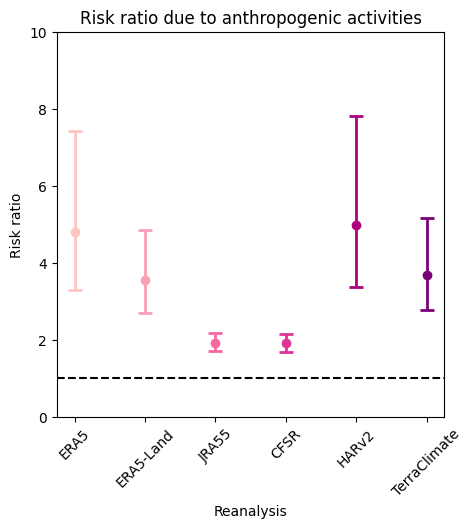

In [13]:
# plot the risk ratio of observed SWEI
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
obs_colors_2 = ['#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#6e016b']
obs_colors_3 = ['#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']
# ax.errorbar( range(6), risk_ratio, yerr = [risk_ratio - risk_ratio_boot.quantile(0.025), risk_ratio_boot.quantile(0.975) - risk_ratio], fmt = 'o', color = obs_colors[4], capsize = 5, capthick = 2, elinewidth = 2)
for i,rn in enumerate(obs_SWEI_2020_2022.index):
    ax.errorbar(i, risk_ratio[i], yerr = [[risk_ratio[i] - risk_ratio_boot[rn].quantile(0.025)], [risk_ratio_boot[rn].quantile(0.975) - risk_ratio[i]]], fmt = 'o', color = obs_colors_3[i], capsize = 5, capthick = 2, elinewidth = 2)

ax.set_ylabel('Risk ratio')
ax.set_xlabel('Reanalysis')
ax.set_title('Risk ratio due to anthropogenic activities')
ax.set_xticks(range(6))
ax.set_xticklabels(obs_SWEI_2020_2022.index,rotation = 45)
ax.axhline(1, color = 'black', linestyle = '--')
ax.set_ylim(0, 10)

plt.show()

In [14]:
# calculate risk ratio of observed SWEI due to ENSO events
# the risk ratio is defined as the ratio of the probability of SWEI being lower than the 2020-2022 average under La Nina to the probability of SWEI being lower than the 2020-2022 average under all ENSO phases
# the risk ratio is calculated for all climate models
obs_SWEI_2020_2022 = obs_SWEI_yearly['2020':'2022'].mean(axis=0,skipna=True)
hist_SWEI_nina = CMIP6_hist_SWEI_yearly_nina_stack[0]
hist_SWEI_all = CMIP6_hist_SWEI_yearly_stack[0]
# calculate the probability of SWEI being lower than the 2020-2022 average under La Nina (hist_SWEI_nina)，firstly fitting a normal distribution to the data, then calculate the probability
hist_nina_prob_normal = stats.norm.fit(hist_SWEI_nina)
hist_nina_prob = stats.norm.cdf(obs_SWEI_2020_2022, loc = hist_nina_prob_normal[0], scale = hist_nina_prob_normal[1])
# calculate the probability of SWEI being lower than the 2020-2022 average under all ENSO phases (hist_SWEI_all)，firstly fitting a normal distribution to the data, then calculate the probability
hist_all_prob_normal = stats.norm.fit(hist_SWEI_all)
hist_all_prob = stats.norm.cdf(obs_SWEI_2020_2022, loc = hist_all_prob_normal[0], scale = hist_all_prob_normal[1])
# calculate the risk ratio
risk_ratio_nina = hist_nina_prob/hist_all_prob

# calculate the 95% confidence interval of the risk ratio based on the 1000-member bootstrapping method
risk_ratio_nina_boot = []

for i in range(1000):
    hist_SWEI_nina_boot = np.random.choice(hist_SWEI_nina, len(hist_SWEI_nina), replace = True)
    hist_SWEI_all_boot = np.random.choice(hist_SWEI_all, len(hist_SWEI_all), replace = True)
    hist_nina_prob_normal_boot = stats.norm.fit(hist_SWEI_nina_boot)
    hist_nina_prob_boot = stats.norm.cdf(obs_SWEI_2020_2022, loc = hist_nina_prob_normal_boot[0], scale = hist_nina_prob_normal_boot[1])
    hist_all_prob_normal_boot = stats.norm.fit(hist_SWEI_all_boot)
    hist_all_prob_boot = stats.norm.cdf(obs_SWEI_2020_2022, loc = hist_all_prob_normal_boot[0], scale = hist_all_prob_normal_boot[1])
    risk_ratio_nina_boot.append(hist_nina_prob_boot/hist_all_prob_boot)

risk_ratio_nina_boot = np.array(risk_ratio_nina_boot)
risk_ratio_nina_boot = pd.DataFrame(risk_ratio_nina_boot)
risk_ratio_nina_boot.columns = obs_SWEI_2020_2022.index

In [15]:
risk_ratio_nina

array([1.88593976, 1.74956979, 1.39900972, 1.39305761, 1.90126797,
       1.77035511])

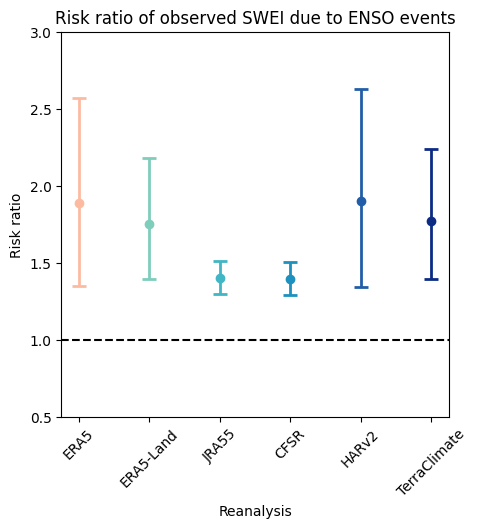

In [16]:
# plot the risk ratio of observed SWEI due to ENSO events
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
obs_colors_2 = ['#fcbba1','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
obs_colors_3 = ['#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']
for i,rn in enumerate(obs_SWEI_2020_2022.index):
    ax.errorbar(i, risk_ratio_nina[i], yerr = [[risk_ratio_nina[i] - risk_ratio_nina_boot[rn].quantile(0.025)], [risk_ratio_nina_boot[rn].quantile(0.975) - risk_ratio_nina[i]]], fmt = 'o', color = obs_colors_2[i], capsize = 5, capthick = 2, elinewidth = 2)

ax.set_ylabel('Risk ratio')
ax.set_xlabel('Reanalysis')
ax.set_title('Risk ratio of observed SWEI due to ENSO events')
ax.set_xticks(range(6))
ax.set_xticklabels(obs_SWEI_2020_2022.index,rotation = 45)
ax.axhline(1, color = 'black', linestyle = '--')
ax.set_ylim(0.5, 3)
ax.grid(False)
plt.show()


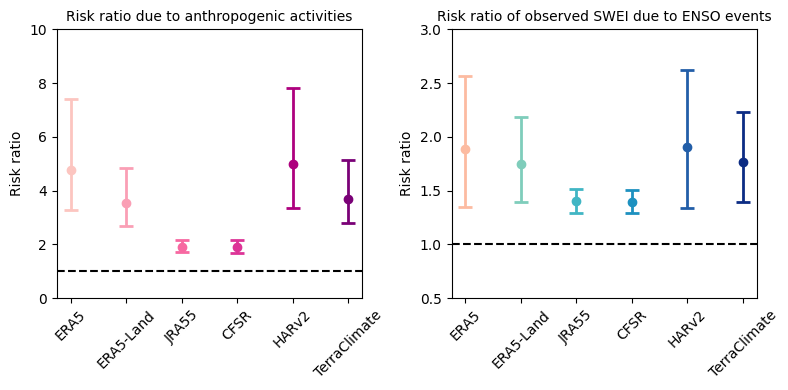

In [39]:
# plot a 1 * 2 figure to show the risk ratio of observed SWEI due to anthropogenic activities and ENSO events
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
obs_colors_2 = ['#fcbba1','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
obs_colors_3 = ['#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']
for i,rn in enumerate(obs_SWEI_2020_2022.index):
    ax[0].errorbar(i, risk_ratio[i], yerr = [[risk_ratio[i] - risk_ratio_boot[rn].quantile(0.025)], [risk_ratio_boot[rn].quantile(0.975) - risk_ratio[i]]], fmt = 'o', color = obs_colors_3[i], capsize = 5, capthick = 2, elinewidth = 2)
    ax[1].errorbar(i, risk_ratio_nina[i], yerr = [[risk_ratio_nina[i] - risk_ratio_nina_boot[rn].quantile(0.025)], [risk_ratio_nina_boot[rn].quantile(0.975) - risk_ratio_nina[i]]], fmt = 'o', color = obs_colors_2[i], capsize = 5, capthick = 2, elinewidth = 2)

ax[0].set_ylabel('Risk ratio')
# ax[0].set_xlabel('Reanalysis')
ax[0].set_title('Risk ratio due to anthropogenic activities', fontsize = 10)
ax[0].set_xticks(range(6))
ax[0].set_xticklabels(obs_SWEI_2020_2022.index,rotation = 45)
ax[0].axhline(1, color = 'black', linestyle = '--')
ax[0].set_ylim(0, 10)
ax[0].grid(False)

ax[1].set_ylabel('Risk ratio')
# ax[1].set_xlabel('Reanalysis')
ax[1].set_title('Risk ratio of observed SWEI due to ENSO events', fontsize = 10)
ax[1].set_xticks(range(6))
ax[1].set_xticklabels(obs_SWEI_2020_2022.index,rotation = 45)
ax[1].axhline(1, color = 'black', linestyle = '--')
ax[1].set_ylim(0.5, 3)
ax[1].grid(False)

plt.tight_layout()
plt.show()

In [18]:
CMIP6_hist_STI_yearly = pd.read_csv('CMIP6_hist/CMIP6_hist_STI3_all_yearly_1950_2025.csv', index_col = 0)
CMIP6_hist_STI_yearly.index = pd.date_range(start = '1949-01-01', end = '2024-01-01', freq = 'AS') # the year is water year
CMIP6_hist_STI_yearly = CMIP6_hist_STI_yearly['1979':'2022']

CMIP6_NAT_STI_yearly = pd.read_csv('CMIP6_NAT/CMIP6_nat_STI3_all_yearly_1950_2020.csv', index_col = 0)
CMIP6_NAT_STI_yearly.index = pd.date_range(start = '1949-01-01', end = '2019-01-01', freq = 'AS')
CMIP6_NAT_STI_yearly = CMIP6_NAT_STI_yearly['1970':'2019']

CMIP6_hist_SPI_yearly = pd.read_csv('CMIP6_hist/CMIP6_hist_SPI3_all_yearly_1950_2025.csv', index_col = 0)
CMIP6_hist_SPI_yearly.index = pd.date_range(start = '1949-01-01', end = '2024-01-01', freq = 'AS') # the year is water year
CMIP6_hist_SPI_yearly = CMIP6_hist_SPI_yearly['1979':'2022']

CMIP6_NAT_SPI_yearly = pd.read_csv('CMIP6_NAT/CMIP6_nat_SPI3_all_yearly_1950_2020.csv', index_col = 0)
CMIP6_NAT_SPI_yearly.index = pd.date_range(start = '1949-01-01', end = '2019-01-01', freq = 'AS')
CMIP6_NAT_SPI_yearly = CMIP6_NAT_SPI_yearly['1970':'2019']

# select STI of EL Nino and La Nina years for each climate model under historical and NAT scenarios

CMIP6_hist_STI_yearly_nino = pd.DataFrame()
CMIP6_hist_STI_yearly_nino.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_STI_yearly_nina = pd.DataFrame()
CMIP6_hist_STI_yearly_nina.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_STI_yearly_normal = pd.DataFrame()
CMIP6_hist_STI_yearly_normal.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_STI_yearly_nino = pd.DataFrame()
CMIP6_NAT_STI_yearly_nino.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_STI_yearly_nina = pd.DataFrame()
CMIP6_NAT_STI_yearly_nina.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_STI_yearly_normal = pd.DataFrame()
CMIP6_NAT_STI_yearly_normal.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year

CMIP6_hist_SPI_yearly_nino = pd.DataFrame()
CMIP6_hist_SPI_yearly_nino.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_SPI_yearly_nina = pd.DataFrame()
CMIP6_hist_SPI_yearly_nina.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_SPI_yearly_normal = pd.DataFrame()
CMIP6_hist_SPI_yearly_normal.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SPI_yearly_nino = pd.DataFrame()
CMIP6_NAT_SPI_yearly_nino.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SPI_yearly_nina = pd.DataFrame()
CMIP6_NAT_SPI_yearly_nina.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SPI_yearly_normal = pd.DataFrame()
CMIP6_NAT_SPI_yearly_normal.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year

for sn in hist_source:
    if sn == 'GFDL-CM4':
        continue
    NINO3 = hist_nino3[sn]
    NINO3 = NINO3['1979':'2022']
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    NINO3_QS_DJF.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year

    STI = CMIP6_hist_STI_yearly[sn]
    STI = STI['1979':'2022']
    STI_nino = STI.loc[NINO3_QS_DJF[NINO3_QS_DJF > 0.5].index,]
    CMIP6_hist_STI_yearly_nino[sn] = STI_nino
    STI_nina = STI.loc[NINO3_QS_DJF[NINO3_QS_DJF < -0.5].index,]
    CMIP6_hist_STI_yearly_nina[sn] = STI_nina
    STI_normal = STI.loc[NINO3_QS_DJF[(NINO3_QS_DJF < 0.5) & (NINO3_QS_DJF > -0.5)].index,]
    CMIP6_hist_STI_yearly_normal[sn] = STI_normal

for sn in NAT_source:
    if sn == 'GFDL-CM4':
        continue
    NINO3 = NAT_nino3[sn]
    NINO3 = NINO3['1970':'2019']
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    NINO3_QS_DJF.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year

    STI = CMIP6_NAT_STI_yearly[sn]
    STI = STI['1970':'2019']
    STI_nino = STI.loc[NINO3_QS_DJF[NINO3_QS_DJF > 0.5].index,]
    CMIP6_NAT_STI_yearly_nino[sn] = STI_nino
    STI_nina = STI.loc[NINO3_QS_DJF[NINO3_QS_DJF < -0.5].index,]
    CMIP6_NAT_STI_yearly_nina[sn] = STI_nina
    STI_normal = STI.loc[NINO3_QS_DJF[(NINO3_QS_DJF < 0.5) & (NINO3_QS_DJF > -0.5)].index,]
    CMIP6_NAT_STI_yearly_normal[sn] = STI_normal

# select SPI of EL Nino and La Nina years for each climate model under historical and NAT scenarios

CMIP6_hist_SPI_yearly_nino = pd.DataFrame()
CMIP6_hist_SPI_yearly_nino.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_SPI_yearly_nina = pd.DataFrame()
CMIP6_hist_SPI_yearly_nina.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_hist_SPI_yearly_normal = pd.DataFrame()
CMIP6_hist_SPI_yearly_normal.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SPI_yearly_nino = pd.DataFrame()
CMIP6_NAT_SPI_yearly_nino.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SPI_yearly_nina = pd.DataFrame()
CMIP6_NAT_SPI_yearly_nina.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year
CMIP6_NAT_SPI_yearly_normal = pd.DataFrame()
CMIP6_NAT_SPI_yearly_normal.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year

for sn in hist_source:
    if sn == 'GFDL-CM4':
        continue
    NINO3 = hist_nino3[sn]
    NINO3 = NINO3['1979':'2022']
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    NINO3_QS_DJF.index = pd.date_range(start = '1979-01-01', end = '2022-01-01', freq = 'AS') # the year is water year

    SPI = CMIP6_hist_SPI_yearly[sn]
    SPI = SPI['1979':'2022']
    SPI_nino = SPI.loc[NINO3_QS_DJF[NINO3_QS_DJF > 0.5].index,]
    CMIP6_hist_SPI_yearly_nino[sn] = SPI_nino
    SPI_nina = SPI.loc[NINO3_QS_DJF[NINO3_QS_DJF < -0.5].index,]
    CMIP6_hist_SPI_yearly_nina[sn] = SPI_nina
    SPI_normal = SPI.loc[NINO3_QS_DJF[(NINO3_QS_DJF < 0.5) & (NINO3_QS_DJF > -0.5)].index,]
    CMIP6_hist_SPI_yearly_normal[sn] = SPI_normal

for sn in NAT_source:
    if sn == 'GFDL-CM4':
        continue
    NINO3 = NAT_nino3[sn]
    NINO3 = NINO3['1970':'2019']
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    NINO3_QS_DJF.index = pd.date_range(start = '1970-01-01', end = '2019-01-01', freq = 'AS') # the year is water year

    SPI = CMIP6_NAT_SPI_yearly[sn]
    SPI = SPI['1970':'2019']
    SPI_nino = SPI.loc[NINO3_QS_DJF[NINO3_QS_DJF > 0.5].index,]
    CMIP6_NAT_SPI_yearly_nino[sn] = SPI_nino
    SPI_nina = SPI.loc[NINO3_QS_DJF[NINO3_QS_DJF < -0.5].index,]
    CMIP6_NAT_SPI_yearly_nina[sn] = SPI_nina
    SPI_normal = SPI.loc[NINO3_QS_DJF[(NINO3_QS_DJF < 0.5) & (NINO3_QS_DJF > -0.5)].index,]
    CMIP6_NAT_SPI_yearly_normal[sn] = SPI_normal

In [19]:
CMIP6_hist_SPI_yearly_stack = CMIP6_hist_SPI_yearly.stack().reset_index()
CMIP6_hist_SPI_yearly_nino_stack = CMIP6_hist_SPI_yearly_nino.stack().reset_index()
CMIP6_hist_SPI_yearly_nina_stack = CMIP6_hist_SPI_yearly_nina.stack().reset_index()
CMIP6_hist_SPI_yearly_normal_stack = CMIP6_hist_SPI_yearly_normal.stack().reset_index()

CMIP6_NAT_SPI_yearly_nino_stack = CMIP6_NAT_SPI_yearly_nino.stack().reset_index()
CMIP6_NAT_SPI_yearly_nina_stack = CMIP6_NAT_SPI_yearly_nina.stack().reset_index()
CMIP6_NAT_SPI_yearly_normal_stack = CMIP6_NAT_SPI_yearly_normal.stack().reset_index()
CMIP6_NAT_SPI_yearly_stack = CMIP6_NAT_SPI_yearly.stack().reset_index()

CMIP6_hist_STI_yearly_stack = CMIP6_hist_STI_yearly.stack().reset_index()
CMIP6_hist_STI_yearly_nino_stack = CMIP6_hist_STI_yearly_nino.stack().reset_index()
CMIP6_hist_STI_yearly_nina_stack = CMIP6_hist_STI_yearly_nina.stack().reset_index()
CMIP6_hist_STI_yearly_normal_stack = CMIP6_hist_STI_yearly_normal.stack().reset_index()

CMIP6_NAT_STI_yearly_nino_stack = CMIP6_NAT_STI_yearly_nino.stack().reset_index()
CMIP6_NAT_STI_yearly_nina_stack = CMIP6_NAT_STI_yearly_nina.stack().reset_index()
CMIP6_NAT_STI_yearly_normal_stack = CMIP6_NAT_STI_yearly_normal.stack().reset_index()
CMIP6_NAT_STI_yearly_stack = CMIP6_NAT_STI_yearly.stack().reset_index()

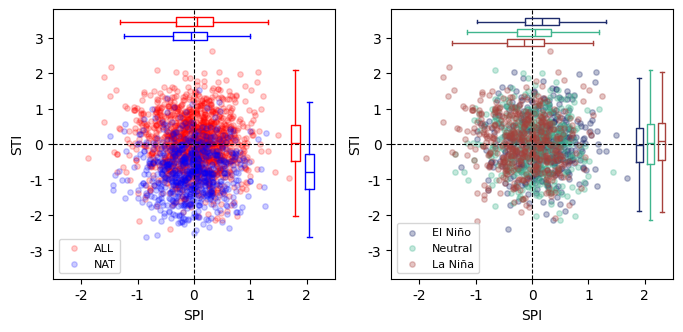

In [37]:
# create a figure with SPI as the x axis and STI as the y axis, the left panel shows the scatter plot of all climate models, the right panel shows the scatter plot of El Nino and normal years

fig, ax = plt.subplots(ncols=2,nrows=1, figsize = (8, 3.5))
colors0 = ['red','blue']
ax[0].scatter(x=CMIP6_hist_SPI_yearly_stack[0],y=CMIP6_hist_STI_yearly_stack[0],color='red',alpha=0.2, label = 'ALL', s = 15)
ax[0].scatter(x=CMIP6_NAT_SPI_yearly_stack[0],y=CMIP6_NAT_STI_yearly_stack[0],color='blue',alpha=0.2, label = 'NAT', s = 15)
ax[0].set_xlim(-2.5,2.5)
ax[0].set_ylim(-3.8,3.8)
ax[0].set_xlabel('SPI',fontsize=10)
ax[0].set_ylabel('STI',fontsize=10)
ax[0].axvline(x=0, color = 'black', linestyle = '--', linewidth=0.8)
ax[0].axhline(y=0, color = 'black', linestyle = '--', linewidth=0.8)

boxprops1 = dict(linestyle='-', linewidth=1, color='red')
boxprops2 = dict(linestyle='-', linewidth=1, color='blue')
boxprops3 = dict(linestyle='-', linewidth=1, color='#1E2C6C')
boxprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
boxprops5 = dict(linestyle='-', linewidth=1, color='#a7413c')
whiskerprops1 = dict(linestyle='-', linewidth=1, color='red')
whiskerprops2 = dict(linestyle='-', linewidth=1, color='blue')
whiskerprops3 = dict(linestyle='-', linewidth=1, color='#1E2C6C')
whiskerprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
whiskerprops5 = dict(linestyle='-', linewidth=1, color='#a7413c')
capprops1 = dict(linestyle='-', linewidth=1, color='red')
capprops2 = dict(linestyle='-', linewidth=1, color='blue')
capprops3 = dict(linestyle='-', linewidth=1, color='#1E2C6C')
capprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
capprops5 = dict(linestyle='-', linewidth=1, color='#a7413c')
medianprops1 = dict(linestyle='-', linewidth=1, color='red')
medianprops2 = dict(linestyle='-', linewidth=1, color='blue')
medianprops3 = dict(linestyle='-', linewidth=1, color='#1E2C6C')
medianprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
medianprops5 = dict(linestyle='-', linewidth=1, color='#a7413c')

ax[0].boxplot(x = CMIP6_hist_SPI_yearly_stack[0], vert=False, positions=[3.45],widths=0.24,showfliers=False,boxprops=boxprops1,whiskerprops=whiskerprops1,capprops=capprops1,medianprops=medianprops1)
ax[0].boxplot(x = CMIP6_NAT_SPI_yearly_stack[0], vert=False, positions=[3.05],widths=0.24,showfliers=False,boxprops=boxprops2,whiskerprops=whiskerprops2,capprops=capprops2,medianprops=medianprops2)
ax[0].boxplot(x = CMIP6_hist_STI_yearly_stack[0], vert=True, positions=[1.8],widths=0.16,showfliers=False,boxprops=boxprops1,whiskerprops=whiskerprops1,capprops=capprops1,medianprops=medianprops1)
ax[0].boxplot(x = CMIP6_NAT_STI_yearly_stack[0], vert=True, positions=[2.05],widths=0.16,showfliers=False,boxprops=boxprops2,whiskerprops=whiskerprops2,capprops=capprops2,medianprops=medianprops2)
ax[0].set_ylim(-3.8,3.8)
ax[0].set_yticks([-3,-2,-1,0,1,2,3])
ax[0].set_yticklabels([-3,-2,-1,0,1,2,3])
ax[0].set_xticks([-2,-1,0,1,2])
ax[0].set_xticklabels([-2,-1,0,1,2])

ax[1].scatter(x=CMIP6_hist_SPI_yearly_nino_stack[0],y=CMIP6_hist_STI_yearly_nino_stack[0],color='#1E2C6C',alpha=0.3, label = 'El Niño', s = 15)
ax[1].scatter(x=CMIP6_hist_SPI_yearly_normal_stack[0],y=CMIP6_hist_STI_yearly_normal_stack[0],color='#40B58E',alpha=0.3, label = 'Neutral', s = 15)
ax[1].scatter(x=CMIP6_hist_SPI_yearly_nina_stack[0],y=CMIP6_hist_STI_yearly_nina_stack[0],color='#a7413c',alpha=0.3, label = 'La Niña', s = 15)
ax[1].set_xlim(-2.5,2.5)
ax[1].set_ylim(-3.8,3.8)
ax[1].set_xlabel('SPI',fontsize=10)
ax[1].set_ylabel('STI',fontsize=10)
ax[1].axvline(x=0, color = 'black', linestyle = '--', linewidth=0.8)
ax[1].axhline(y=0, color = 'black', linestyle = '--', linewidth=0.8)

ax[1].boxplot(x = CMIP6_hist_SPI_yearly_nino_stack[0], vert=False, positions=[3.45],widths=0.2,showfliers=False,boxprops=boxprops3,whiskerprops=whiskerprops3,capprops=capprops3,medianprops=medianprops3)
ax[1].boxplot(x = CMIP6_hist_SPI_yearly_normal_stack[0], vert=False, positions=[3.15],widths=0.2,showfliers=False,boxprops=boxprops4,whiskerprops=whiskerprops4,capprops=capprops4,medianprops=medianprops4)
ax[1].boxplot(x = CMIP6_hist_SPI_yearly_nina_stack[0], vert=False, positions=[2.85],widths=0.2,showfliers=False,boxprops=boxprops5,whiskerprops=whiskerprops5,capprops=capprops5,medianprops=medianprops5)
ax[1].boxplot(x = CMIP6_hist_STI_yearly_nino_stack[0], vert=True, positions=[1.9],widths=0.125,showfliers=False,boxprops=boxprops3,whiskerprops=whiskerprops3,capprops=capprops3,medianprops=medianprops3)
ax[1].boxplot(x = CMIP6_hist_STI_yearly_normal_stack[0], vert=True, positions=[2.1],widths=0.125,showfliers=False,boxprops=boxprops4,whiskerprops=whiskerprops4,capprops=capprops4,medianprops=medianprops4)
ax[1].boxplot(x = CMIP6_hist_STI_yearly_nina_stack[0], vert=True, positions=[2.3],widths=0.125,showfliers=False,boxprops=boxprops5,whiskerprops=whiskerprops5,capprops=capprops5,medianprops=medianprops5)

ax[1].set_yticks([-3,-2,-1,0,1,2,3])
ax[1].set_yticklabels([-3,-2,-1,0,1,2,3])
ax[1].set_xticks([-2,-1,0,1,2])
ax[1].set_xticklabels([-2,-1,0,1,2])

# add a legend
ax[0].legend(loc='lower left',fontsize=8)
ax[1].legend(loc='lower left',fontsize=8)

In [69]:
# t-test for determining whether CMIP6_hist_SPI_yearly_stack[0] and CMIP6_NAT_SPI_yearly_stack[0] belong to the same distribution
# <0.05 means their distribution are significantly different
print('t-test for SPI of ALL and NAT:')
ttest_SPI_all_nat = ttest_ind(CMIP6_hist_SPI_yearly_stack[0], CMIP6_NAT_SPI_yearly_stack[0], equal_var = False)
print(ttest_SPI_all_nat)
print('t-test for STI of ALL and NAT:')
ttest_STI_all_nat = ttest_ind(CMIP6_hist_STI_yearly_stack[0], CMIP6_NAT_STI_yearly_stack[0], equal_var = False)
print(ttest_STI_all_nat)
print('t-test for SPI of El Niño and La Niña:')
ttest_SPI_nino_nina = ttest_ind(CMIP6_hist_SPI_yearly_nino_stack[0], CMIP6_hist_SPI_yearly_nina_stack[0], equal_var = False)
print(ttest_SPI_nino_nina)
print('t-test for STI of El Niño and La Niña:')
ttest_STI_nino_nina = ttest_ind(CMIP6_hist_STI_yearly_nino_stack[0], CMIP6_hist_STI_yearly_nina_stack[0], equal_var = False)
print(ttest_STI_nino_nina)
print('t-test for SPI of El Niño and Normal years:')
ttest_SPI_nino_normal = ttest_ind(CMIP6_hist_SPI_yearly_nino_stack[0], CMIP6_hist_SPI_yearly_normal_stack[0], equal_var = False)
print(ttest_SPI_nino_normal)
print('t-test for STI of El Niño and Normal years:')
ttest_STI_nino_normal = ttest_ind(CMIP6_hist_STI_yearly_nino_stack[0], CMIP6_hist_STI_yearly_normal_stack[0], equal_var = False)
print(ttest_STI_nino_normal)
print('t-test for SPI of La Niña and Normal years:')
ttest_SPI_nina_normal = ttest_ind(CMIP6_hist_SPI_yearly_nina_stack[0], CMIP6_hist_SPI_yearly_normal_stack[0], equal_var = False)
print(ttest_SPI_nina_normal)
print('t-test for STI of La Niña and Normal years:')
ttest_STI_nina_normal = ttest_ind(CMIP6_hist_STI_yearly_nina_stack[0], CMIP6_hist_STI_yearly_normal_stack[0], equal_var = False)
print(ttest_STI_nina_normal)


t-test for SPI of ALL and NAT:
Ttest_indResult(statistic=3.6114434347452105, pvalue=0.00031509532227433254)
t-test for STI of ALL and NAT:
Ttest_indResult(statistic=23.42482534504706, pvalue=2.789627032207883e-103)
t-test for SPI of El Niño and La Niña:
Ttest_indResult(statistic=10.407131389293399, pvalue=4.783833755048342e-24)
t-test for STI of El Niño and La Niña:
Ttest_indResult(statistic=-1.4141544140038533, pvalue=0.15766885617101703)
t-test for SPI of El Niño and Normal years:
Ttest_indResult(statistic=4.57140157253393, pvalue=5.562831353492009e-06)
t-test for STI of El Niño and Normal years:
Ttest_indResult(statistic=-0.4526071598180558, pvalue=0.6509467805553957)
t-test for SPI of La Niña and Normal years:
Ttest_indResult(statistic=-5.960514186064221, pvalue=3.552671699658432e-09)
t-test for STI of La Niña and Normal years:
Ttest_indResult(statistic=0.9347937480892266, pvalue=0.350142778164516)


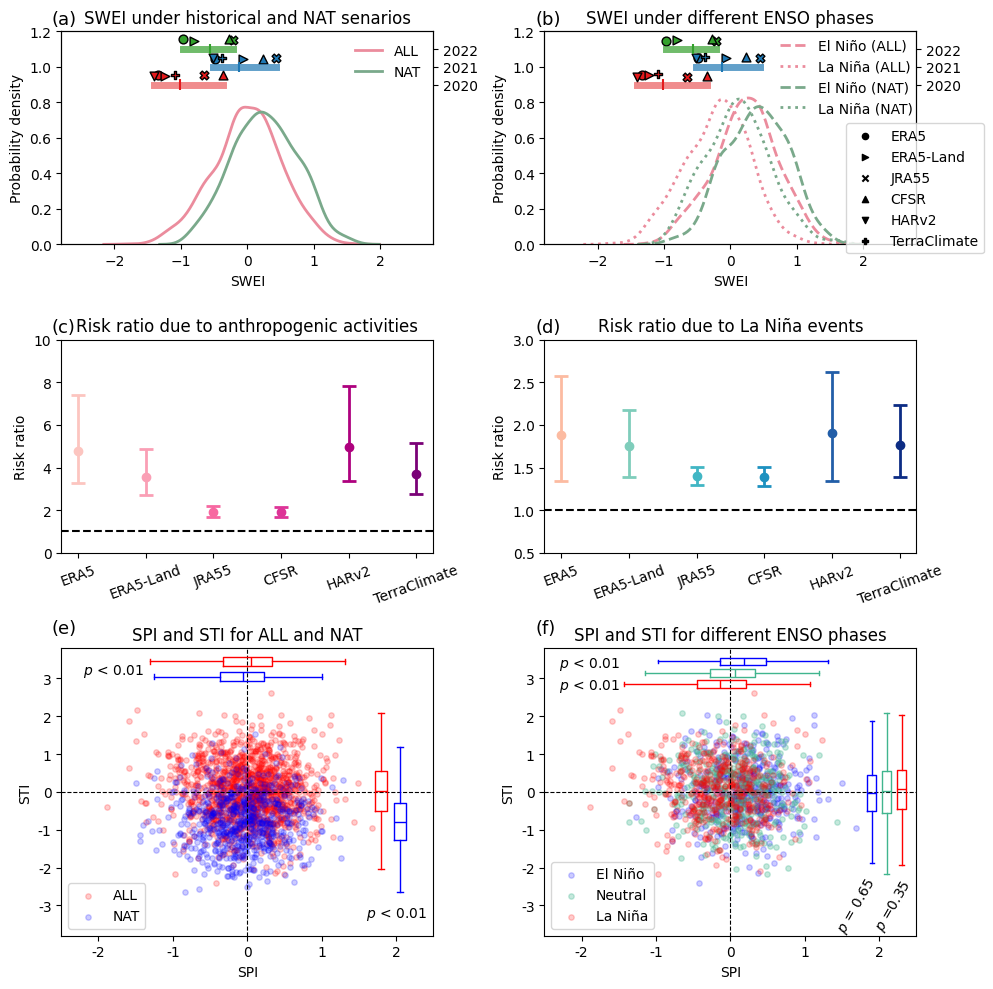

In [85]:
# plot a 3 * 2 figure to show all of the above figures
# the first row shows the probability density function of SWEI under historical and NAT senarios
# the second row shows the risk ratio of observed SWEI due to anthropogenic activities and ENSO events
# the third row shows the scatter plot of SPI and STI, the left panel shows the scatter plot of all climate models, the right panel shows the scatter plot of El Nino and normal years

def add_panel_label(ax, label, x = -0.025, y = 1.1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=13, fontweight='normal', va='top', ha='left')

fig, ax = plt.subplots(ncols=2,nrows=3, figsize = (10, 10), gridspec_kw = {'height_ratios':[1,1,1.35]})

# plot the first row
sns.kdeplot(CMIP6_hist_SWEI_yearly_stack[0], color = '#eb8c9d', ax = ax[0,0], linestyle = '-',linewidth = 2)
sns.kdeplot(CMIP6_NAT_SWEI_yearly_stack[0], color = '#7aa98b', ax = ax[0,0], linestyle = '-',linewidth = 2)
sns.kdeplot(CMIP6_hist_SWEI_yearly_nino_stack[0], color = '#eb8c9d', ax = ax[0,1], linestyle = '--', linewidth = 2)
sns.kdeplot(CMIP6_hist_SWEI_yearly_nina_stack[0], color = '#eb8c9d', ax = ax[0,1], linestyle = ':' , linewidth = 2)
sns.kdeplot(CMIP6_NAT_SWEI_yearly_nino_stack[0], color = '#7aa98b', ax = ax[0,1], linestyle = '--', linewidth = 2)
sns.kdeplot(CMIP6_NAT_SWEI_yearly_nina_stack[0], color = '#7aa98b', ax = ax[0,1], linestyle = ':', linewidth = 2)

ax[0,0].set_ylabel('Probability density')
ax[0,0].set_xlabel('SWEI')
ax[0,0].set_xlim(-2.8, 2.8)
ax[0,0].set_ylim(0, 1.2)
ax[0,0].set_title('SWEI under historical and NAT senarios')
ax[0,0].legend(['ALL', 'NAT'], fontsize = 10, fancybox = False, frameon = False)
# add vertical lines to indicate the value of obs_SWEI_2020_2022
obs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']


ax[0,1].set_ylabel('Probability density')
ax[0,1].set_xlabel('SWEI')
ax[0,1].set_xlim(-2.8, 2.8)
ax[0,1].set_ylim(0, 1.2)
ax[0,1].set_title('SWEI under different ENSO phases')
ax[0,1].legend(['El Niño (ALL)', 'La Niña (ALL)', 'El Niño (NAT)', 'La Niña (NAT)'], loc = 'upper right', bbox_to_anchor=(1.025,1.025), fontsize = 10, fancybox = False, frameon = False)


# create twin axis to plot the boxplot
ax2 = ax[0,0].twinx()
mean_2020 = obs_SWEI_yearly['2020':'2020'].mean(axis=1)
mean_2021 = obs_SWEI_yearly['2021':'2021'].mean(axis=1)
mean_2022 = obs_SWEI_yearly['2022':'2022'].mean(axis=1)
ax2.plot([obs_SWEI_yearly['2020':'2020'].stack().min(), obs_SWEI_yearly['2020':'2020'].stack().max()], [0.9, 0.9], color = obs_colors[5], linestyle = '-', linewidth = 5, alpha = 0.5)
ax2.plot([obs_SWEI_yearly['2021':'2021'].stack().min(), obs_SWEI_yearly['2021':'2021'].stack().max()], [1.0, 1.0], color = obs_colors[1], linestyle = '-', linewidth = 5, alpha = 0.7)
ax2.plot([obs_SWEI_yearly['2022':'2022'].stack().min(), obs_SWEI_yearly['2022':'2022'].stack().max()], [1.1, 1.1], color = obs_colors[3], linestyle = '-', linewidth = 5, alpha = 0.7)
ax2.set_ylim(0, 1.2)
ax2.vlines(mean_2020.values, ymax=0.9+0.03, ymin=0.9-0.03, color = obs_colors[5], linestyle = '-')
ax2.vlines(mean_2021.values, ymax=1.0+0.03, ymin=1.0-0.03, color = obs_colors[1], linestyle = '-')
ax2.vlines(mean_2022.values, ymax=1.1+0.03, ymin=1.1-0.03, color = obs_colors[3], linestyle = '-')

ax2.set_yticks([ 0.9,1.0, 1.1])
ax2.set_yticklabels([2020, 2021, 2022])

def rand_jitter(num):
    return num + np.random.randn() * 0.005

for i,rn in enumerate(['ERA5', 'ERA5-Land', 'JRA55', 'CFSR', 'HARv2', 'TerraClimate']):# with different markers, add random value to avoid overlap
    ax2.scatter(obs_SWEI_yearly.T['2020-01-01'][rn], rand_jitter(0.95), color = obs_colors[5], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax2.scatter(obs_SWEI_yearly.T['2021-01-01'][rn], rand_jitter(1.05), color = obs_colors[1], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax2.scatter(obs_SWEI_yearly.T['2022-01-01'][rn], rand_jitter(1.15), color = obs_colors[3], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')

ax3 = ax[0,1].twinx()
ax3.plot([obs_SWEI_yearly['2020':'2020'].stack().min(), obs_SWEI_yearly['2020':'2020'].stack().max()], [0.9, 0.9], color = obs_colors[5], linestyle = '-', linewidth = 5, alpha = 0.5)
ax3.plot([obs_SWEI_yearly['2021':'2021'].stack().min(), obs_SWEI_yearly['2021':'2021'].stack().max()], [1.0, 1.0], color = obs_colors[1], linestyle = '-', linewidth = 5, alpha = 0.7)
ax3.plot([obs_SWEI_yearly['2022':'2022'].stack().min(), obs_SWEI_yearly['2022':'2022'].stack().max()], [1.1, 1.1], color = obs_colors[3], linestyle = '-', linewidth = 5, alpha = 0.7)
ax3.set_ylim(0, 1.2)
ax3.vlines(mean_2020.values, ymax=0.9+0.03, ymin=0.9-0.03, color = obs_colors[5], linestyle = '-')
ax3.vlines(mean_2021.values, ymax=1.0+0.03, ymin=1.0-0.03, color = obs_colors[1], linestyle = '-')
ax3.vlines(mean_2022.values, ymax=1.1+0.03, ymin=1.1-0.03, color = obs_colors[3], linestyle = '-')
ax3.set_yticks([ 0.9, 1.0, 1.1])
ax3.set_yticklabels([2020, 2021, 2022])

# add legend for scatter plot
ax3.scatter([],[], color = 'black', s = 20, marker = 'o', label = 'ERA5')
ax3.scatter([],[], color = 'black', s = 20, marker = '>', label = 'ERA5-Land')
ax3.scatter([],[], color = 'black', s = 20, marker = 'x', label = 'JRA55')
ax3.scatter([],[], color = 'black', s = 20, marker = '^', label = 'CFSR')
ax3.scatter([],[], color = 'black', s = 20, marker = 'v', label = 'HARv2')
ax3.scatter([],[], color = 'black', s = 20, marker = 'P', label = 'TerraClimate')
ax3.legend(loc = 'upper right', bbox_to_anchor=(1.2, 0.6), fontsize = 10)

for i,rn in enumerate(['ERA5', 'ERA5-Land', 'JRA55', 'CFSR', 'HARv2', 'TerraClimate']):# with different markers, add random value to avoid overlap
    ax3.scatter(obs_SWEI_yearly.T['2020-01-01'][rn], rand_jitter(0.95), color = obs_colors[5], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax3.scatter(obs_SWEI_yearly.T['2021-01-01'][rn], rand_jitter(1.05), color = obs_colors[1], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')
    ax3.scatter(obs_SWEI_yearly.T['2022-01-01'][rn], rand_jitter(1.15), color = obs_colors[3], s = 40, marker = ['o','>','X','^','v','P'][i], edgecolor = 'black')

ax[0,0].grid(False)
ax[0,1].grid(False)
ax2.grid(False)
ax3.grid(False)

# plot the second row
obs_colors_2 = ['#fcbba1','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
obs_colors_3 = ['#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']
for i,rn in enumerate(obs_SWEI_2020_2022.index):
    ax[1,0].errorbar(i, risk_ratio[i], yerr = [[risk_ratio[i] - risk_ratio_boot[rn].quantile(0.025)], [risk_ratio_boot[rn].quantile(0.975) - risk_ratio[i]]], fmt = 'o', color = obs_colors_3[i], capsize = 5, capthick = 2, elinewidth = 2)
    ax[1,1].errorbar(i, risk_ratio_nina[i], yerr = [[risk_ratio_nina[i] - risk_ratio_nina_boot[rn].quantile(0.025)], [risk_ratio_nina_boot[rn].quantile(0.975) - risk_ratio_nina[i]]], fmt = 'o', color = obs_colors_2[i], capsize = 5, capthick = 2, elinewidth = 2)

ax[1,0].set_ylabel('Risk ratio')
# ax[1,0].set_xlabel('Reanalysis')
ax[1,0].set_title('Risk ratio due to anthropogenic activities')
ax[1,0].set_xticks(range(6))
ax[1,0].set_xticklabels(obs_SWEI_2020_2022.index,rotation = 20)
ax[1,0].axhline(1, color = 'black', linestyle = '--')
ax[1,0].set_ylim(0, 10)
ax[1,0].grid(False)

ax[1,1].set_ylabel('Risk ratio')
# ax[1,1].set_xlabel('Reanalysis')
ax[1,1].set_title('Risk ratio due to La Niña events')
ax[1,1].set_xticks(range(6))
ax[1,1].set_xticklabels(obs_SWEI_2020_2022.index,rotation = 20)
ax[1,1].axhline(1, color = 'black', linestyle = '--')
ax[1,1].set_ylim(0.5, 3)
ax[1,1].grid(False)

# plot the third row
colors0 = ['red','blue']
ax[2,0].scatter(x=CMIP6_hist_SPI_yearly_stack[0],y=CMIP6_hist_STI_yearly_stack[0],color='red',alpha=0.2, label = 'ALL', s = 15)
ax[2,0].scatter(x=CMIP6_NAT_SPI_yearly_stack[0],y=CMIP6_NAT_STI_yearly_stack[0],color='blue',alpha=0.2, label = 'NAT', s = 15)
ax[2,0].set_xlim(-2.5,2.5)
ax[2,0].set_ylim(-3.8,3.8)
ax[2,0].set_xlabel('SPI',fontsize=10)
ax[2,0].set_ylabel('STI',fontsize=10)
ax[2,0].axvline(x=0, color = 'black', linestyle = '--', linewidth=0.8)
ax[2,0].axhline(y=0, color = 'black', linestyle = '--', linewidth=0.8)

boxprops1 = dict(linestyle='-', linewidth=1, color='red')
boxprops2 = dict(linestyle='-', linewidth=1, color='blue')
boxprops3 = dict(linestyle='-', linewidth=1, color='blue')
boxprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
boxprops5 = dict(linestyle='-', linewidth=1, color='red')
whiskerprops1 = dict(linestyle='-', linewidth=1, color='red')
whiskerprops2 = dict(linestyle='-', linewidth=1, color='blue')
whiskerprops3 = dict(linestyle='-', linewidth=1, color='blue')
whiskerprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
whiskerprops5 = dict(linestyle='-', linewidth=1, color='red')
capprops1 = dict(linestyle='-', linewidth=1, color='red')
capprops2 = dict(linestyle='-', linewidth=1, color='blue')
capprops3 = dict(linestyle='-', linewidth=1, color='blue')
capprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
capprops5 = dict(linestyle='-', linewidth=1, color='red')
medianprops1 = dict(linestyle='-', linewidth=1, color='red')
medianprops2 = dict(linestyle='-', linewidth=1, color='blue')
medianprops3 = dict(linestyle='-', linewidth=1, color='blue')
medianprops4 = dict(linestyle='-', linewidth=1, color='#40B58E')
medianprops5 = dict(linestyle='-', linewidth=1, color='red')

ax[2,0].boxplot(x = CMIP6_hist_SPI_yearly_stack[0], vert=False, positions=[3.45],widths=0.24,showfliers=False,boxprops=boxprops1,whiskerprops=whiskerprops1,capprops=capprops1,medianprops=medianprops1)
ax[2,0].boxplot(x = CMIP6_NAT_SPI_yearly_stack[0], vert=False, positions=[3.05],widths=0.24,showfliers=False,boxprops=boxprops2,whiskerprops=whiskerprops2,capprops=capprops2,medianprops=medianprops2)
ax[2,0].boxplot(x = CMIP6_hist_STI_yearly_stack[0], vert=True, positions=[1.8],widths=0.16,showfliers=False,boxprops=boxprops1,whiskerprops=whiskerprops1,capprops=capprops1,medianprops=medianprops1)
ax[2,0].boxplot(x = CMIP6_NAT_STI_yearly_stack[0], vert=True, positions=[2.05],widths=0.16,showfliers=False,boxprops=boxprops2,whiskerprops=whiskerprops2,capprops=capprops2,medianprops=medianprops2)
ax[2,0].set_ylim(-3.8,3.8)
ax[2,0].set_yticks([-3,-2,-1,0,1,2,3])
ax[2,0].set_yticklabels([-3,-2,-1,0,1,2,3])
ax[2,0].set_xticks([-2,-1,0,1,2])
ax[2,0].set_xticklabels([-2,-1,0,1,2])

# add ttest pvalue to the plot
# for ttest_SPI_all_nat
ax[2,0].text(-1.8, 3.2, '$\it{p}$ < 0.01', fontsize = 10, color = 'black', ha = 'center', va = 'center',)
# for ttest_STI_all_nat
ax[2,0].text(2, -3.2, '$\it{p}$ < 0.01', fontsize = 10, color = 'black', ha = 'center', va = 'center',)

ax[2,1].scatter(x=CMIP6_hist_SPI_yearly_nino_stack[0],y=CMIP6_hist_STI_yearly_nino_stack[0],color='blue',alpha=0.2, label = 'El Niño', s = 15)
ax[2,1].scatter(x=CMIP6_hist_SPI_yearly_normal_stack[0],y=CMIP6_hist_STI_yearly_normal_stack[0],color='#40B58E',alpha=0.3, label = 'Neutral', s = 15)
ax[2,1].scatter(x=CMIP6_hist_SPI_yearly_nina_stack[0],y=CMIP6_hist_STI_yearly_nina_stack[0],color='red',alpha=0.2, label = 'La Niña', s = 15)
ax[2,1].set_xlim(-2.5,2.5)
ax[2,1].set_ylim(-3.8,3.8)
ax[2,1].set_xlabel('SPI',fontsize=10)
ax[2,1].set_ylabel('STI',fontsize=10)
ax[2,1].axvline(x=0, color = 'black', linestyle = '--', linewidth=0.8)
ax[2,1].axhline(y=0, color = 'black', linestyle = '--', linewidth=0.8)

ax[2,1].boxplot(x = CMIP6_hist_SPI_yearly_nino_stack[0], vert=False, positions=[3.45],widths=0.2,showfliers=False,boxprops=boxprops3,whiskerprops=whiskerprops3,capprops=capprops3,medianprops=medianprops3)
ax[2,1].boxplot(x = CMIP6_hist_SPI_yearly_normal_stack[0], vert=False, positions=[3.15],widths=0.2,showfliers=False,boxprops=boxprops4,whiskerprops=whiskerprops4,capprops=capprops4,medianprops=medianprops4)
ax[2,1].boxplot(x = CMIP6_hist_SPI_yearly_nina_stack[0], vert=False, positions=[2.85],widths=0.2,showfliers=False,boxprops=boxprops5,whiskerprops=whiskerprops5,capprops=capprops5,medianprops=medianprops5)
ax[2,1].boxplot(x = CMIP6_hist_STI_yearly_nino_stack[0], vert=True, positions=[1.9],widths=0.125,showfliers=False,boxprops=boxprops3,whiskerprops=whiskerprops3,capprops=capprops3,medianprops=medianprops3)
ax[2,1].boxplot(x = CMIP6_hist_STI_yearly_normal_stack[0], vert=True, positions=[2.1],widths=0.125,showfliers=False,boxprops=boxprops4,whiskerprops=whiskerprops4,capprops=capprops4,medianprops=medianprops4)
ax[2,1].boxplot(x = CMIP6_hist_STI_yearly_nina_stack[0], vert=True, positions=[2.3],widths=0.125,showfliers=False,boxprops=boxprops5,whiskerprops=whiskerprops5,capprops=capprops5,medianprops=medianprops5)

ax[2,1].set_yticks([-3,-2,-1,0,1,2,3])
ax[2,1].set_yticklabels([-3,-2,-1,0,1,2,3])
ax[2,1].set_xticks([-2,-1,0,1,2])
ax[2,1].set_xticklabels([-2,-1,0,1,2])

ax[2,0].legend(loc='lower left',fontsize=10)
ax[2,1].legend(loc='lower left',fontsize=10)
ax[2,0].set_title('SPI and STI for ALL and NAT')
ax[2,1].set_title('SPI and STI for different ENSO phases')

# add ttest pvalue to the plot
# for ttest_SPI_nino_normal
ax[2,1].text(-1.9, 3.4, '$\it{p}$ < 0.01', fontsize = 10, color = 'black', ha = 'center', va = 'center',)
# for ttest_SPI_nina_normal
ax[2,1].text(-1.9, 2.8, '$\it{p}$ < 0.01', fontsize = 10, color = 'black', ha = 'center', va = 'center',)
# for ttest_STI_nino_normal
ax[2,1].text(1.7, -3., '$\it{p}$ = ' + str(round(ttest_STI_nino_normal[1],2)), fontsize = 10, color = 'black', ha = 'center', va = 'center', rotation = 60)
# for ttest_STI_nina_normal
ax[2,1].text(2.2, -3., '$\it{p}$ ='  + str(round(ttest_STI_nina_normal[1],2)), fontsize = 10, color = 'black', ha = 'center', va = 'center', rotation = 60)


# add panel label
add_panel_label(ax[0,0], '(a)')
add_panel_label(ax[0,1], '(b)')
add_panel_label(ax[1,0], '(c)')
add_panel_label(ax[1,1], '(d)')
add_panel_label(ax[2,0], '(e)')
add_panel_label(ax[2,1], '(f)')

plt.tight_layout()
plt.show()

# save the figure
fig.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Figure3.png', dpi=300, bbox_inches='tight')
fig.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Figure3.pdf', bbox_inches='tight')